<a href="https://www.kaggle.com/code/jarredpriester/2nd-attempt-mnist-accuracy-99?scriptVersionId=100383446" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# My 2nd Attempt at MNIST

### Jarred Priester
### 7/8/22

1. Introduction
2. Downloading the data
3. Processing the images
4. Model
5. Predictions
6. Conclusion

# 1. Introduction

In my first submission for the Kaggle Digit Recognizer competition I submitted a simple yet affective model with the accuracy score of 98%. In this notebook I will attempt to beat that score by adding more layers to the first model.

The first submission can be found here for comparison:
https://www.kaggle.com/code/jarredpriester/my-first-cnn

# 2. Downloading the data

In [1]:
#importing libaries
import numpy as np 
import pandas as pd
import random as rd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.applications.vgg16 import VGG16

#setting seed for reproducability
from numpy.random import seed
seed(10)
tf.random.set_seed(20)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
#downloading the sample submission
sample_sub = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
sample_sub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [3]:
#downloading the training data
train = pd.read_csv("../input/digit-recognizer/train.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#downloading the test data
test = pd.read_csv("../input/digit-recognizer/test.csv")
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3. Processing the images

In the training data set we can see that the first column is 'label' and the rest are pixels. We will use the label column as our Y and the rest as our X

In [5]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 

Next we need to scale the data from 0-255 to 0-1. This will make things easier to work with the neural network because it will allow the nn to converge faster.

In [6]:
X_train = X_train / 255.0
test = test / 255.0

The images will need to be reshaped in order feed into our model. Our images will be 28x28 and since we will be using grayscale the color channel will be 1.

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [8]:
print(X_train.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


Now that the data has been scaled and reshaped we can now split our training data into training and validation sets. The split will be 90% to train on and 10% to use as validation. Which leaves us with the test data which will we be making our predictions on.

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=5)

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(37800, 28, 28, 1)
(37800,)
(4200, 28, 28, 1)
(4200,)


Let us take a look at an image from the training set so we have a visual of the images we are working with

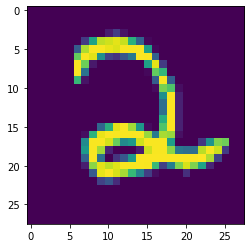

In [11]:
plt.imshow(X_train[18])

# 4. Model

The orginal plan for this model was to use a pretrained model. That plan did not work, I was unable to find a pretrained model that fit these images. If you know of any please feel free to let me know in the comments. The second plan was to use data augmentation but to my surprise the training results were worst than the orginal model. The third plan was to add additonal layers to the orginal model. Adding batch normalization and dropout layers to the orginal model did improve the validaton loss and validation accuracy from the orginal model.

In [12]:
model = keras.Sequential([
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same',
                  input_shape=[28, 28, 1]),
    layers.MaxPool2D(),
    layers.Dropout(.1),
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(.1),
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(.1),
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(.1),
    
    layers.Flatten(),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=10, activation="softmax"),
])

2022-07-09 03:26:40.444874: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    x = X_train,
    y = Y_train, 
    validation_data= (X_val,Y_val),
    batch_size = 128,
    epochs=20,
    verbose=2,
)

2022-07-09 03:26:40.670455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
296/296 - 34s - loss: 0.5794 - accuracy: 0.8252 - val_loss: 1.0146 - val_accuracy: 0.5755
Epoch 2/20
296/296 - 32s - loss: 0.1074 - accuracy: 0.9664 - val_loss: 0.0624 - val_accuracy: 0.9824
Epoch 3/20
296/296 - 32s - loss: 0.0730 - accuracy: 0.9775 - val_loss: 0.0472 - val_accuracy: 0.9864
Epoch 4/20
296/296 - 32s - loss: 0.0580 - accuracy: 0.9819 - val_loss: 0.0394 - val_accuracy: 0.9879
Epoch 5/20
296/296 - 31s - loss: 0.0468 - accuracy: 0.9859 - val_loss: 0.0371 - val_accuracy: 0.9890
Epoch 6/20
296/296 - 32s - loss: 0.0394 - accuracy: 0.9871 - val_loss: 0.0361 - val_accuracy: 0.9898
Epoch 7/20
296/296 - 33s - loss: 0.0344 - accuracy: 0.9886 - val_loss: 0.0328 - val_accuracy: 0.9898
Epoch 8/20
296/296 - 32s - loss: 0.0309 - accuracy: 0.9902 - val_loss: 0.0327 - val_accuracy: 0.9912
Epoch 9/20
296/296 - 32s - loss: 0.0280 - accuracy: 0.9911 - val_loss: 0.0355 - val_accuracy: 0.9890
Epoch 10/20
296/296 - 33s - loss: 0.0236 - accuracy: 0.9928 - val_loss: 0.0317 - val_accura

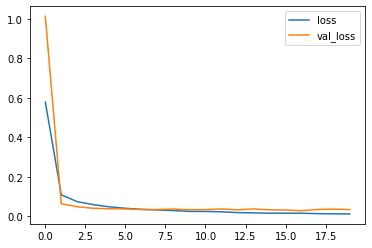

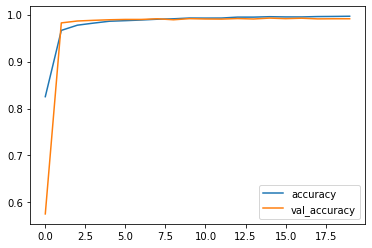

In [15]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

# 5. Predictions

In [16]:
predictions = model.predict(test)

predictions = np.argmax(predictions,axis = 1)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("submissions.csv", index=False, header=True)

submissions.head(20)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


# 6. Conclusion

We started with the task of improving on the result from our first model, a result of 98% accuracy. By applying batch normalization and dropout layers to the orginal model we were able to improve the validation loss to .029 and the validation accuracy to 99%, achieving our objective of improving our first model.